In [1]:
import torch
import inspect
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.activation as A
from tqdm import tqdm
%pylab inline
import torchvision
import torchvision.transforms as transforms
from livelossplot import PlotLosses
import os, errno

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist_data = torchvision.datasets.MNIST('./datasets/mnist', download=True, train=True,
                                           transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=32, shuffle=True)
cifar_data = torchvision.datasets.CIFAR10('./datasets/cifar10', download=True, train=True, \
                                          transform=transforms.Compose([
#                                               transforms.Resize(64),
                                              transforms.ToTensor(), 
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
cifar_loader = torch.utils.data.DataLoader(cifar_data, batch_size=64, shuffle=True)

Files already downloaded and verified


In [3]:
list(mnist_loader)[3][0].shape

torch.Size([32, 1, 28, 28])

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# cifar10_path = "./cifar-10-batches-py/"
# batch1 = unpickle(cifar10_path + 'data_batch_1')
# import matplotlib.pyplot as plt
# b = batch1[b'data'][4].reshape(3, 32, 32).transpose(1,2,0).astype("uint8")
# # plt.imshow(b)
# b1_reshaped = batch1[b'data'].reshape(batch1[b'data'].shape[0], 3, 32, 32)
# b1_reshaped[0].shape
# plt.imshow(b1_reshaped[1000].transpose(1, 2, 0))
# b1_reshaped[0]

In [ ]:
def makeChannels(max_channel, reverse=False, num_channels=3):
    assert max_channel % 2==0
    channels = [max_channel]
    for i in range(1,num_channels):
        channels.append(channels[i-1]//2)
    if reverse:
        channels.reverse()
        return channels
    return channels

class GeneratorNet(nn.Module):
    def __init__(self, cz=100, gf_dim=64, img_channels=3, img_size=64):
        super(GeneratorNet, self).__init__()
        channels = makeChannels(8*gf_dim, num_channels=4)
        print("G channels " + str(channels))
        layer_list = [
            # Project and reshape
            nn.ConvTranspose2d(cz, channels[0], 4, 1, 0, bias=False),
            A.ReLU(True),
            nn.BatchNorm2d(channels[0]),
            # Conv1. (?, channels[0], 4, 4) -> (?, channels[1], 8, 8)
            nn.ConvTranspose2d(channels[0], channels[1], 4, 2, 1, bias=False),
            A.ReLU(True),
            nn.BatchNorm2d(channels[1]),
            # Conv2. (?, channels[1], 8, 8) -> (?, channels[2], 16, 16)
            nn.ConvTranspose2d(channels[1], channels[2], 4, 2, 1, bias=False),
            A.ReLU(True),
            nn.BatchNorm2d(channels[2])]
        
        if img_size==28:
            layer_list.extend([
                    ### MNIST (?, channels[2], 16, 16) -> (?, img_channels=1, 28, 28) 
                    nn.ConvTranspose2d(channels[2], img_channels, 4, 2, 3, bias=False),
                    A.Tanh()
                ]
            )
        elif img_size==32:
            layer_list.extend([
                    ## CIFAR (?, channels[2], 16, 16) -> (?, img_channels=3, 32, 32)
                    nn.ConvTranspose2d(channels[2], img_channels, 4, 2, 1, bias=True),            
                    A.Tanh()
                ])
        elif img_size==64:
            layer_list.extend([
                    #  Conv3. (?, channels[2], 16, 16) -> (?, channels[3], 32, 32)
                    nn.ConvTranspose2d(channels[2], channels[3], 4, 2, 1, bias=False),
                    A.ReLU(True),
                    nn.BatchNorm2d(channels[3]),
                    #  Conv4. (?, channels[3], 32, 32) -> (?, 3, 64, 64)
                    nn.ConvTranspose2d(channels[3], img_channels, 4, 2, 1, bias=False),
                    A.Tanh()
            ]
            )
        self.model = nn.Sequential(*layer_list)
        
    def forward(self, z):
        """
        Input: 
            - z: minibatch of 1D noise vectors/"codes"
        Shapes:
            - z: (N, C) where N is batch_size and C is channels of z.
        """
        return self.model(z)

class DiscriminatorNet(nn.Module):
    def __init__(self, gf_dim=64, img_channels=3, img_size=64):
        super(DiscriminatorNet, self).__init__()
        channels = makeChannels(8*gf_dim, num_channels=4, reverse=True)
        print("D channels " + str(channels))
        layer_list = [
            # Project image 
            nn.Conv2d(img_channels, channels[0], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # conv1
            nn.Conv2d(channels[0], channels[1], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(channels[1]),
            # Conv2
            nn.Conv2d(channels[1], channels[2], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(channels[2]),
        ]
        
        if img_size==28:
            layer_list.extend([
                nn.Conv2d(channels[2], 1, 3, 1, 0, bias=False),
                nn.Sigmoid()
                ]
            )
        elif img_size==32:
            layer_list.extend([
                nn.Conv2d(channels[2], 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
                ]
            )  
        elif img_size==64:
            layer_list.extend([
                nn.Conv2d(channels[2], channels[3], 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm2d(channels[3]),

                nn.Conv2d(channels[3], 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
                ]
            )
        self.model = nn.Sequential(*layer_list)
        
        
    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [ ]:
img_channels=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G=GeneratorNet(cz=100, gf_dim=64, img_channels=img_channels, img_size=32)
D=DiscriminatorNet(img_channels=img_channels, img_size=32)
gopt = optim.Adam(G.parameters(), lr=0.0002, betas=(.5, .999))
dopt = optim.Adam(D.parameters(), lr=0.0002, betas=(.5, .999))

criterion = nn.BCELoss()

G channels [512, 256, 128, 64]
D channels [64, 128, 256, 512]


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
import re
def latest_checkpoint(folder):
#     import ipdb; ipdb.set_trace()
    walk = list(os.walk(folder))
    if not walk:
        return None
    _, _, files = walk[0]
    regex = re.compile(r'epoch\d+_mbatch\d+')
    files = list(filter(regex.search, files))
    files = sorted(files, key=lambda x: [int(num) for num in re.findall(r'\d+', x)], reverse=True)
    return folder + "/" + files[0] if len(files) > 0 else None

# latest_checkpoint("./chkpts/D")

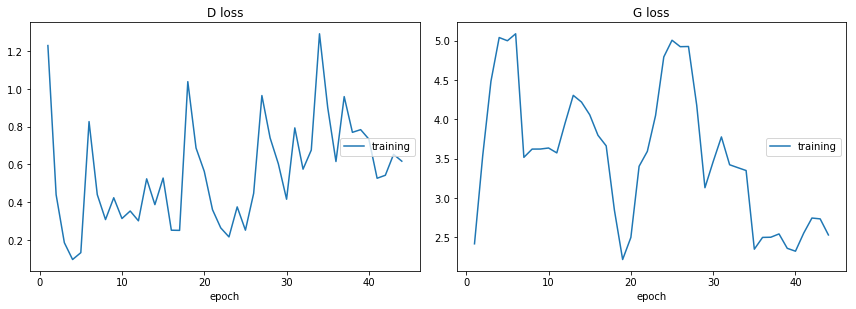

443it [05:29,  1.32it/s]

In [ ]:
liveloss = PlotLosses()

mbatch_mod = 10
cz=100
epoch_mod = 2
checkpt_dir = "./checkpoints/"

### LOAD CHECKPOINT ###
checkD = latest_checkpoint(checkpt_dir + "D")
checkG = latest_checkpoint(checkpt_dir + "G")
if checkD and checkG:
    print("Resuming training with " + str(checkD) + " " + str(checkG))
    G.load_state_dict(torch.load(checkG))
    D.load_state_dict(torch.load(checkD))
G.apply(weights_init)
D.apply(weights_init)

running_dloss = 0.0
running_gloss = 0.0
for epoch in range(100):
    for mbatch_idx, x in tqdm(enumerate(cifar_loader)):
        ##############################
        # Update discriminator 
        ##############################
        D.zero_grad()
        x = x[0]
        x = x.to(device, dtype=torch.float32)
        batch_size = x.shape[0]
        real_loss = criterion(D(x), torch.ones(x.shape[0]))
        real_loss.backward()
        
#         z = torch.zeros([x.shape[0], cz, 1, 1]).uniform_(0, 1)
        z = torch.randn(batch_size, cz, 1, 1)
        fake = G(z)
        generated_loss = criterion(D(fake.detach()), torch.zeros(x.shape[0]))
        generated_loss.backward()

        dloss = real_loss.item() + generated_loss.item()

        dopt.step()
#         dopt.zero_grad()
        
        ##############################
        # Update generator
        ##############################
#         z = torch.zeros([x.shape[0], cz, 1, 1]).uniform_(0, 1) 
        G.zero_grad()
        gloss = criterion(D(fake), torch.ones(x.shape[0]))
        gloss.backward()
        
        gopt.step()
#         gopt.zero_grad()
        
        running_dloss += dloss
        running_gloss += gloss
        if (mbatch_idx % mbatch_mod == 0 and mbatch_idx > 0 and epoch % epoch_mod == 0):
            print(F"Epoch: {epoch}, minibatch: {mbatch_idx}, DLoss: {running_dloss/mbatch_mod}, GLoss: {running_gloss/mbatch_mod}")
            if not os.path.exists(F"{checkpt_dir}G"):
                os.makedirs(F"{checkpt_dir}G")
            if not os.path.exists(F"{checkpt_dir}D"):
                os.makedirs(F"{checkpt_dir}D")
            torch.save(G.state_dict(), F"{checkpt_dir}G/epoch{epoch}_mbatch{mbatch_idx}.pth")
            torch.save(D.state_dict(), F"{checkpt_dir}D/epoch{epoch}_mbatch{mbatch_idx}.pth")
            liveloss.update({
                'D loss':running_dloss/mbatch_mod,
                'G loss':running_gloss/mbatch_mod,
            }
            )
            running_dloss = 0.0
            running_gloss = 0.0
            liveloss.draw()

In [ ]:
testimg = list(mnist_loader)[0][0]

In [ ]:
import torchvision.utils as vutils
# z = torch.zeros([32, 100, 1, 1]).uniform_(0, 1)
z = torch.randn(batch_size, cz, 1, 1)
gen = G(z)
vutils.save_image(gen.detach(), 'fake_samples.png', normalize=True)
# D(gen).shape
gen.shape

# Notes

1. Why does zero'ing out G before update logic lead to much higher GLoss compared to gopt.zero_grad()? (Before doing this, wasn't learning)
3. Resizing 32x32 CIFAR to 64x64 doesn't make difference
4. Weight_init leads to higher starting +2/3 GLoss and +.5 DLoss
5. Make sure channels cascade in right directions
6. Normal distribution noise supresses DLoss growth
7. BatchNorm after activation reduces variance of loss much better compared to pre-activation batchnorm